In [1]:
# import sys; sys.path.append('/rds/general/user/cb2714/home/23-05_canada-wildfires'); from fwi import *
import sys; sys.path.append('/rds/general/user/cb2714/home/'); from wwa import *
import sys; sys.path.append('/rds/general/user/cb2714/home/23-05_canada-wildfires/'); from fwi import *

sf = gpd.read_file("sf_ejb/").to_crs(epsg = 4326)

# **ERA5**
Attempting to diagnose problem with precip data. First, let's check that I get the same FWI when I run Theo's code using the data he shared:

In [116]:
# first, the problem:
pr = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/era5/tp_era5_19400101_20230731.nc").tp
rm = regionmask.mask_3D_geopandas(sf, pr.longitude, pr.latitude).squeeze(drop = True)
pr = pr.where(~np.isnan(pr), 0)
pr_ts = pr.where(rm == 1).mean(["longitude", "latitude"])
pr_ts.groupby("time.dayofyear").mean().plot()
fwi_theo.where(rm == 1).mean(["longitude", "latitude"]).groupby("time.dayofyear").mean().plot()
(pr_ts.groupby("time.month")[6].groupby("time.dayofyear").mean()*2).plot()
(pr_ts.groupby("time.month")[7].groupby("time.dayofyear").mean()*2).plot()

In [123]:
pr_old = xr.open_dataset("era5_tp_19400101-20230729.nc").tp.sel(latitude = rm.latitude, longitude = pr.longitude)
pr_old = pr_old.where(~np.isnan(pr_old), 0).where(rm == 1).mean(["longitude", "latitude"])
pr_old_doy = pr_old.groupby("time.dayofyear").mean()

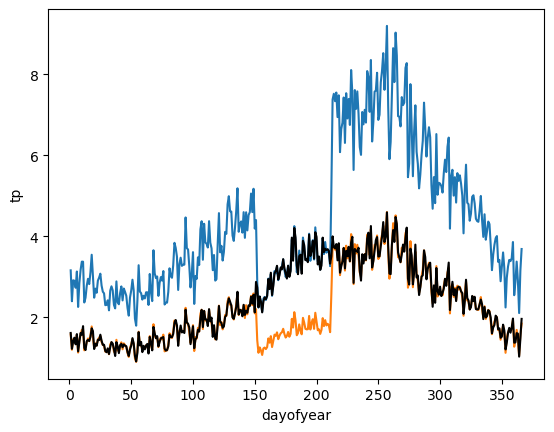

In [154]:
# probably an issue with summing over expver
pr_ts.groupby("time.dayofyear").mean().plot()
(pr_ts.groupby("time.dayofyear").mean()/2).plot()
pr_old.groupby("time.dayofyear").mean().plot(color = "k")

In [135]:
jan = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/99_processing/era5/01_adaptor.mars.internal-1691357798.0010104-26784-11-f89346d2-5581-4d46-8863-fcaf76d69e6a.nc").tp.where(rm == 1).mean(["latitude", "longitude"])
june = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/99_processing/era5/06_adaptor.mars.internal-1691381946.7245328-21116-10-e15890cb-d911-406f-85e9-3403ca879fdd.nc").tp.where(rm == 1).mean(["latitude", "longitude"])

In [148]:
jan_doy = convert_units_to(jan.resample(time = "D").sum().groupby("time.dayofyear").mean(), "mm")
jun_doy = convert_units_to(june.resample(time = "D").sum().groupby("time.dayofyear").mean(), "mm").sel(expver = 1)

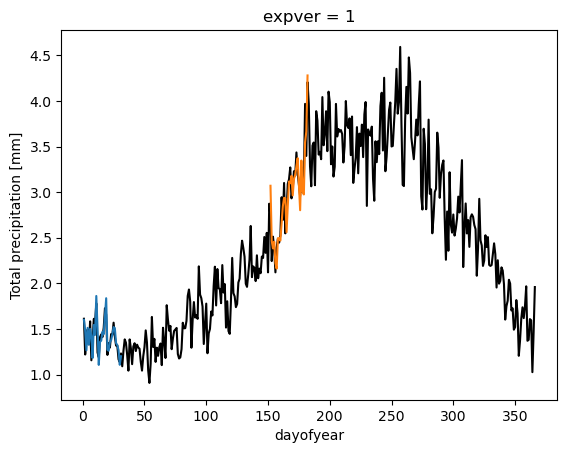

In [152]:
pr_old.groupby("time.dayofyear").mean().plot(color = "k")
jan_doy.plot()
jun_doy.plot()

## **Fix precip data**

In [2]:
pr_x = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/era5/tp_era5_19400101_20230731.nc").tp.sel(latitude = slice(59,47), longitude = slice(-80,-63))

# pr_x is 1600UTC, so want to keep that if possible. But many months are doubled...

zz = [pr_x.groupby("time.month")[m] / 2 for m in [1,2,3,4,5,8,9,10,11,12]] + [pr_x.groupby("time.month")[m] for m in [6,7]]
zz2 = xr.concat(zz, "time").sortby("time").assign_attrs(units = "mm")   # units checked against converted ERA5 data below
zz2.to_netcdf("era5_tp_19400101-20230731_corrected.nc")

In [51]:
jun = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/99_processing/era5/06_adaptor.mars.internal-1691381946.7245328-21116-10-e15890cb-d911-406f-85e9-3403ca879fdd.nc").tp.sel(expver = 5)
jun_24h = convert_units_to(jun.rolling(time = 24).sum().groupby("time.hour")[16], "mm")

In [12]:
jan = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/99_processing/era5/01_adaptor.mars.internal-1691357798.0010104-26784-11-f89346d2-5581-4d46-8863-fcaf76d69e6a.nc").tp
jan_24h = convert_units_to(jan.rolling(time = 24).sum().groupby("time.hour")[16], "mm")

In [80]:
y = "2000"
pr.sel(time = y).mean(["latitude", "longitude"]).plot(color = "k", label = "Theo data to July 29th", figsize = (10,4))
# pr_x.sel(time = "2023").mean(["latitude", "longitude"]).plot(label = "Theo data used", color = "tab:orange")
zz2.sel(time = y).mean(["latitude", "longitude"]).plot(label = "?corrected data", color = "tab:green", ls = "--")

# jan_24h.sel(time = "2023").mean(["latitude", "longitude"]).plot(color = "tab:blue")
# jun_24h.sel(time = "2023").mean(["latitude", "longitude"]).plot(color = "tab:blue")

### **Check**

In [13]:
pr_adj = xr.open_dataset("era5_tp_19400101-20230731_corrected.nc").tp
pr_org = xr.open_dataset("era5_tp_19400101-20230729.nc").tp
pr_wrong = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/era5/tp_era5_19400101_20230731.nc").tp.sel(latitude = slice(59,47), longitude = slice(-80,-63))

rm = regionmask.mask_3D_geopandas(sf, zz2.longitude, zz2.latitude).squeeze(drop = True)

pr_org.where(rm == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean().plot(color = "k")
pr_adj.where(rm == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean().plot()
pr_wrong.where(rm == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean().plot()

jan_24h.where(rm == 1).mean(["latitude", "longitude"]).groupby("time.dayofyear").mean().plot()

### **Double-check against raw ERA5 data**

In [6]:
pr_adj = xr.open_dataset("era5_tp_19400101-20230731_corrected.nc").tp

sf = gpd.read_file("sf_ejb/").to_crs(epsg = 4326)
rm = regionmask.mask_3D_geopandas(sf, pr_adj.longitude, pr_adj.latitude).squeeze(drop = True)

pr_adj = pr_adj.where(rm == 1).mean(["latitude", "longitude"])

In [7]:
# load the bits of data I've managed to download from ERA5
era5_chunks = [xr.open_dataset(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/99_processing/era5/"+str(m).rjust(2,"0")+"_adaptor.*.nc")[0]).tp for m in [1,3,6,8,10,11,12]]
era5_chunks = [da.resample(time = "D").sum().where(rm == 1).mean(["latitude", "longitude"]) for da in era5_chunks]
era5_chunks = [da.sel(expver = 1) if "expver" in da.dims else da for da in era5_chunks]

[[<matplotlib.lines.Line2D at 0x14fb089f0370>],

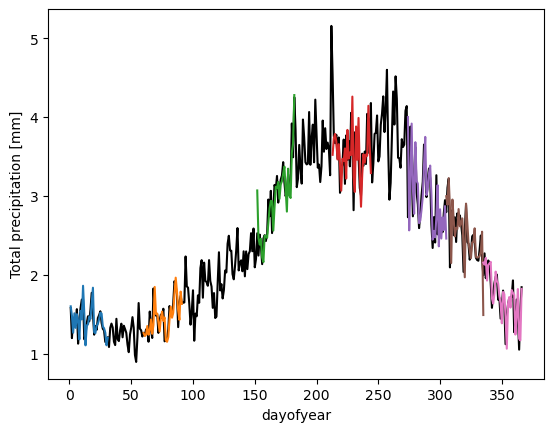

In [8]:
pr_adj.groupby("time.dayofyear").mean().plot(color = "k")
[convert_units_to(da.groupby("time.dayofyear").mean(), "mm").plot() for da in era5_chunks]

# slight difference in timestamps, but that's fine

## **Calculate FWI for corrected ERA5 data**

In [2]:
tas, sfcWind, snw, hurs = [xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/era5/"+varnm+"_era5_19400101_20230731.nc")[varnm] for varnm in ["tas", "sfcWind", "sd", "hurs"]]
pr = xr.open_dataset("era5_tp_19400101-20230731_corrected.nc").tp

months = tas.time.dt.month.to_numpy()
days = tas.time.dt.day.to_numpy()

In [5]:
xr.open_dataset("era5_tp_19400101-20230731_corrected.nc").tp

<xarray.DataArray 'tp' (time: 30528, latitude: 49, longitude: 69)>
[103215168 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -80.0 -79.75 -79.5 ... -63.5 -63.25 -63.0
  * latitude   (latitude) float32 59.0 58.75 58.5 58.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 1940-01-01T16:00:00 ... 2023-07-31T16:00:00
Attributes:
    units:    mm

In [ ]:
print("  ",datetime.now())
ffmc, dmc, dc, isi, bui, fwi = xr.apply_ufunc(lambda t, p, w, h, s : calculate_fwi(months, days, t, p, w, h, s), tas, pr, sfcWind, hurs, snw, 
                                              input_core_dims = [["time"],["time"],["time"],["time"],["time"]], 
                                              output_core_dims = [["time"],["time"],["time"],["time"],["time"],["time"]], vectorize = True)
print("  ",datetime.now())

da = xr.merge([eval(v).rename(v) for v in ["ffmc", "dmc", "dc", "isi", "bui", "fwi"]])
da.to_netcdf("fwi_era5_adjusted-precip_v2.nc")

   2023-08-10 19:14:45.431535


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## **Compute indices for large ensemble**

In [ ]:
# check that CRS reprojection is correct
sf = sf.to_crs(cartopy.crs.RotatedPole(pole_longitude = 83, pole_latitude = 43))

da = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/can_lens/r1_r1/tas_NAM-44_CCCma-CanESM2_historical-r1_r1i1p1_CCCma-CanRCM4_r2_3hr_1950010103-1951010100.nc").tas

da.isel(time = 5).plot()
# sf.boundary.plot(ax = plt.gca(), color = "k")

In [7]:
rm = regionmask.mask_3D_geopandas(sf, da.rlon, da.rlat).squeeze(drop = True)

In [ ]:
fl = glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/cordex/*.nc")

for fnm in fl:
    mdl = "_".join(fnm.split("/")[-1].split("_")[1:5])
    fwi = xr.open_dataset(fnm).fwi.where(rm == 1).squeeze(drop = True)
    xydims = ["rlat", "rlon"]

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## FWI7x FOR CLIMATE EXPLORER
    
    # calculate indices & cut off first year
    fwi7x_ts = fwi.rolling(time = 7).mean().resample(time = "AS-JAN").max().isel(time = slice(1, None)).where(rm == 1).mean(xydims).dropna("time", "any")
    fwi7x_ts = fwi7x_ts.assign_coords(time = fwi7x_ts.time.dt.year).rename(time = "year")
    
    # specify filename
    csv_fnm = "ts/canada-wildfires_fwi7x_"+mdl+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+mdl+" fwi7x - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
    str2 = "# fwi7x [] spatial mean of maximum of 7-day average of FWI over Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year fwi7x"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    fwi7x_ts.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## cumDSR FOR CLIMATE EXPLORER
    
    # compute DSR, set missing values to zero and mask off study region
    dsr = (fwi ** 1.71) * 0.0272
    dsr = dsr.where(~np.isnan(dsr), 0).where(rm == 1)
    
    cumdsr_ts = dsr.sel(time = [m <= 7 for m in dsr.time.dt.month]).resample(time = "AS-JAN").sum().rename("cumdsr").where(rm == 1).mean(xydims)
    cumdsr_ts = cumdsr_ts.assign_coords(time = cumdsr_ts.time.dt.year).rename(time = "year")
    
    # specify filename
    csv_fnm = "ts/canada-wildfires_cumDSR_"+mdl+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+mdl+" cumulative DSR - Canada wildfires 2023, c.barnes22@imperial.ac.uk"
    str2 = "# cumDSR [] spatial mean of cumulative Daily Severity Rating from Jan-July each year over Eastern James Bay region at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year cumDSR"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    cumdsr_ts.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

---
## **Manual calculation of FWI for highresMIP**
_About 13 minutes per run_

In [ ]:
fpath = "../00_WWA_project_folder/ephemeral/canada_fwi/highresmip/"
fl = ["_".join(fnm.split("_")[-4:]) for fnm in glob.glob(fpath+"tas/*.nc")]

for fnm in fl[2:]:
    
    print(fnm)
        
    # load data & align timestamps
    tas = convert_units_to(xr.open_mfdataset(fpath+"tas/*"+fnm).tas.load(), "degC")
    pr = convert_units_to(xr.open_mfdataset(fpath+"pr_24h/*"+fnm).pr.load(), "mm/day")
    sfcWind = convert_units_to(xr.open_mfdataset(fpath+"sfcWind/*"+fnm).sfcWind.load(), "km/hr")
    hurs = xr.open_mfdataset(fpath+"hurs/*"+fnm).hurs.load()
    snw = convert_units_to(xr.open_mfdataset(fpath+"snw/*"+fnm).snw.load(), "m")
    
    P, W, H, S = [da.sel(lon = tas.lon, lat = tas.lat).assign_coords(time = tas.time) for da in [pr, sfcWind, hurs, snw]]

    if not all([len(da.time) == len(tas.time) for da in [P, W, H, S]]):
        print("   ! length mismatch - skipping")
        continue
        
    months = tas.time.dt.month.to_numpy()
    days = tas.time.dt.day.to_numpy()
    
    print("  ",datetime.now())
    ffmc, dmc, dc, isi, bui, fwi = xr.apply_ufunc(lambda t, p, w, h, s : calculate_fwi(months, days, t, p, w, h, s), tas, P, W, H, S, 
                                                  input_core_dims = [["time"],["time"],["time"],["time"],["time"]], 
                                                  output_core_dims = [["time"],["time"],["time"],["time"],["time"],["time"]], vectorize = True)
    print("  ",datetime.now())
    
    da = xr.merge([eval(v).rename(v) for v in ["ffmc", "dmc", "dc", "isi", "bui", "fwi"]])
    da.to_netcdf("model_fwi/fwi_"+fnm)

EC-Earth3P-HR_highresSST-present_r2i1p1f1_gr.nc
   2023-08-08 20:02:45.873889


/rds/general/user/cb2714/home/23-05_canada-wildfires/fwi.py:182: RuntimeWarning: invalid value encountered in long_scalars
  test = np.sum(test) / len(test) > 0.75
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


---
---
## **CMIP6**

In [26]:
for fnm in glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/cmip6/fwi_*.nc"):
    
    da = xr.open_dataset(fnm).fwi
    
    # replace any missing values with 0 (otherwise averaging comes out with wrong numbers)
    da = da.where(~np.isnan(da), 0)
    
    # average over study region
    rm_ejb = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    ts = da.where(rm_ejb == 1).mean(["lon", "lat"])
    
    ts.to_netcdf("data/fwi-ejb_cmip6_"+fnm.split("/")[-1])

## **CanESM-CanRCM large ensemble**

In [27]:
for fnm in glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/cordex/fwi_*.nc"):
    
    da = xr.open_dataset(fnm).fwi

    # replace any missing values with 0 (otherwise averaging comes out with wrong numbers)
    da = da.where(~np.isnan(da), 0)
    
    # average over study region
    rm_ejb = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    ts = da.where(rm_ejb == 1).mean(["rlon", "rlat"])
    
    ts.to_netcdf("data/fwi-ejb_lens_"+fnm.split("/")[-1])

## **CORDEX individual runs**

In [28]:
for fnm in glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/synda/fwi_*.nc"):
    
    da = xr.open_dataset(fnm).fwi

    # replace any missing values with 0 (otherwise averaging comes out with wrong numbers)
    da = da.where(~np.isnan(da), 0)
    
    # average over study region
    rm_ejb = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    ts = da.where(rm_ejb == 1).mean(["rlon", "rlat"])
    
    ts.to_netcdf("data/fwi-ejb_cordex_"+fnm.split("/")[-1])

## **HighResMIP**

In [29]:
for fnm in glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/highresmip/fwi_*.nc"):
    
    da = xr.open_dataset(fnm).fwi
    
    # replace any missing values with 0 (otherwise averaging comes out with wrong numbers)
    da = da.where(~np.isnan(da), 0)
    
    # average over study region
    rm_ejb = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    ts = da.where(rm_ejb == 1).mean(["lon", "lat"])
    
    ts.to_netcdf("data/fwi-ejb_highresmip_"+fnm.split("/")[-1])

## **Quick check of results**

In [6]:
cmip6 = [convert_calendar(xr.open_dataset(fnm).fwi, "default", align_on = "date") for fnm in glob.glob("data/*cmip6*.nc")]

[ts.plot() for ts in cmip6]

In [ ]:
da = xr.open_dataset(glob.glob("../00_WWA_project_folder/ephemeral/canada_fwi/fwi/cmip6/fwi_*.nc")[0]).fwi

In [ ]:
da.mean(["lat", "lon"]).plot()

Text(0.5, 1.0, '')

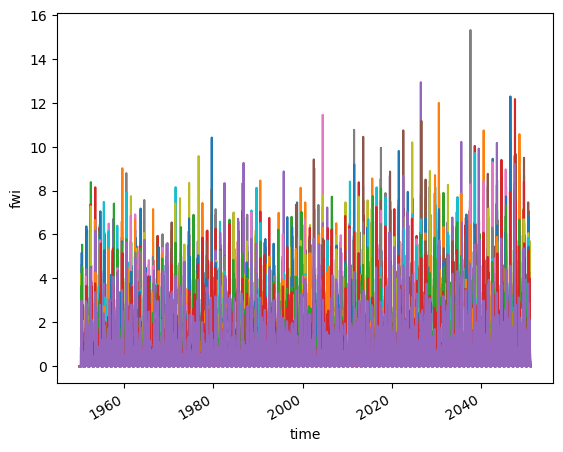

In [2]:
lens = [convert_calendar(xr.open_dataset(fnm).fwi, "default", align_on = "date") for fnm in glob.glob("data/*lens*.nc")]

[ts.plot() for ts in lens]
plt.title("")

Text(0.5, 1.0, '')

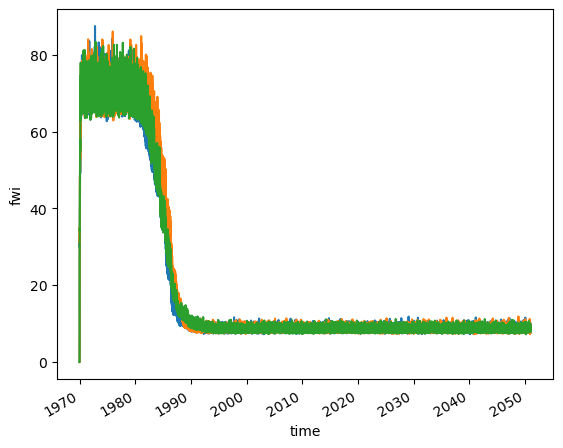

In [4]:
cordex = [convert_calendar(xr.open_dataset(fnm).fwi, "default", align_on = "date") for fnm in glob.glob("data/*cordex*.nc")]

[ts.plot() for ts in cordex]
plt.title("")

Text(0.5, 1.0, 'HighresMIP')

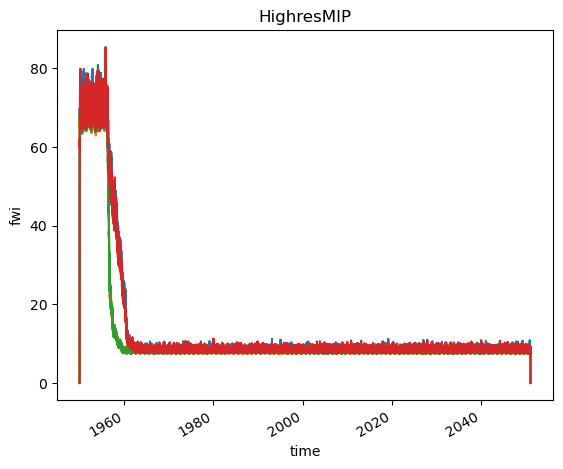

In [11]:
hires = [convert_calendar(xr.open_dataset(fnm).fwi, "default", align_on = "date") for fnm in glob.glob("data/*highresmip*.nc")]

[ts.plot() for ts in hires]
plt.title("HighresMIP")

## **Check raw data**


In [7]:
zz = xr.open_dataset("../00_WWA_project_folder/ephemeral/canada_fwi/cmip6/fwi_ACCESS-CM2_historical_r1i1p1f1_gn.nc").mean(["lat", "lon"])

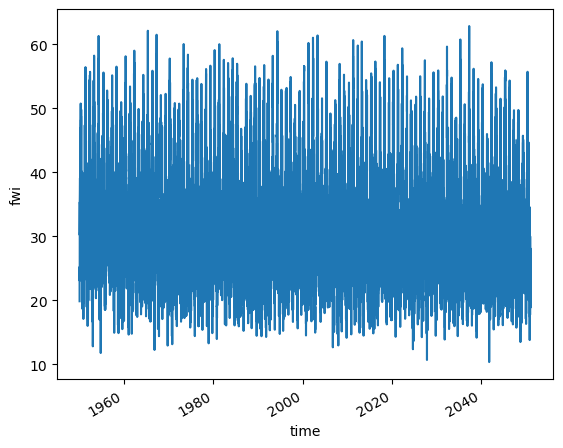

In [9]:
zz.fwi.plot()